![Plant Header](https://carload.com/g/plantheader.png)

# Plant Identification with CNN

## Introduction

There are several commercial phone applications that allow users to identify plants after taking pictures of them. A few examples include PlantNet (https://play.google.com/store/apps/details?id=org.plantnet), Plant.id (https://plant.id/), and LeafSnap (https://play.google.com/store/apps/details?id=plant.identification.snap).

For this project, I wanted to see whether I could use Deep Learning to match these abilities. Since this class has relied on so many competitions hosted on Kaggle, that's where I looked for an appropriate set of data. What I found was "Plant Seedlings Classification" (https://www.kaggle.com/competitions/plant-seedlings-classification/), a Kaggle competition that launched seven years ago. With that timeline, it might have inspired some of those indentification apps.

The task is simple: Differentiate weeds from crops based on how they look at a very early stage. Let's build a model that can perform that task.

We'll start by loading our extra packages.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sn
import sklearn

import tensorflow as tf
from tensorflow import keras

import cv2
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Next, download the data from Kaggle and store it in a virtual directory on Google Colab for speedy access.

In [ ]:
# Install Kaggle API to download the competition data
!pip3 install -q kaggle

os.environ['KAGGLE_USERNAME'] = 'michaelkilgore'
os.environ['KAGGLE_KEY'] = '(a string of hexadecimals)'

# Colab-based root directory
ROOT_DIR = os.path.abspath('./week6')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

# If old data is still around from a previous session, remove it
shutil.rmtree(ROOT_DIR)
os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

In [ ]:
!kaggle competitions download -c plant-seedlings-classification

!unzip -q -o plant-seedlings-classification

os.listdir(os.curdir)

100% 1.68G/1.69G [00:14<00:00, 143MB/s]
100% 1.69G/1.69G [00:14<00:00, 125MB/s]


['sample_submission.csv',
 'plant-seedlings-classification.zip',
 'train',
 'test']

In [ ]:
trainDir = os.path.join(ROOT_DIR, 'train')
testDir = os.path.join(ROOT_DIR, 'test')
print(trainDir)

/content/week6/train


## Exploratory Data Analysis

Let's take a look at the images in the dataset. Are they all the same size and shape?

In [ ]:
smallWidth = 1000
smallHeight = 1000
largeWidth = 200
largeHeight = 200

for dirpath, dirnames, filenames in os.walk(trainDir):
  for filename in filenames:
    if filename.endswith('.png'):
      image = Image.open(os.path.join(dirpath, filename))
      if image.width < smallWidth:
        smallWidth = image.width
      if image.height < smallHeight:
        smallHeight = image.height
      if image.width > largeWidth:
        largeWidth = image.width
      if image.height > largeHeight:
        largeHeight = image.height

print("Narrowest width: ", smallWidth)
print("Shortest height: ", smallHeight)
print("Widest image: ", largeWidth)
print("Tallest image: ", largeHeight)

Narrowest width:  49
Shortest height:  49
Widest image:  3991
Tallest image:  3457


The image dimensions are all over the place, from 49-pixel widths to almost 4000 pixels.

How many images are in each category?

In [ ]:
allCategories = os.listdir(trainDir)
print(allCategories)

['Maize', 'Black-grass', 'Charlock', 'Fat Hen', 'Shepherds Purse', 'Common wheat', 'Sugar beet', 'Common Chickweed', 'Scentless Mayweed', 'Loose Silky-bent', 'Cleavers', 'Small-flowered Cranesbill']


In [ ]:
numCategories = len(allCategories)
catLengthList = []

for category in allCategories:
  catLengthList.append(len(os.listdir(os.path.join(trainDir, category))))
  print('{} {} images'.format(category, len(os.listdir(os.path.join(trainDir, category)))))

Maize 221 images
Black-grass 263 images
Charlock 390 images
Fat Hen 475 images
Shepherds Purse 231 images
Common wheat 221 images
Sugar beet 385 images
Common Chickweed 611 images
Scentless Mayweed 516 images
Loose Silky-bent 654 images
Cleavers 287 images
Small-flowered Cranesbill 496 images


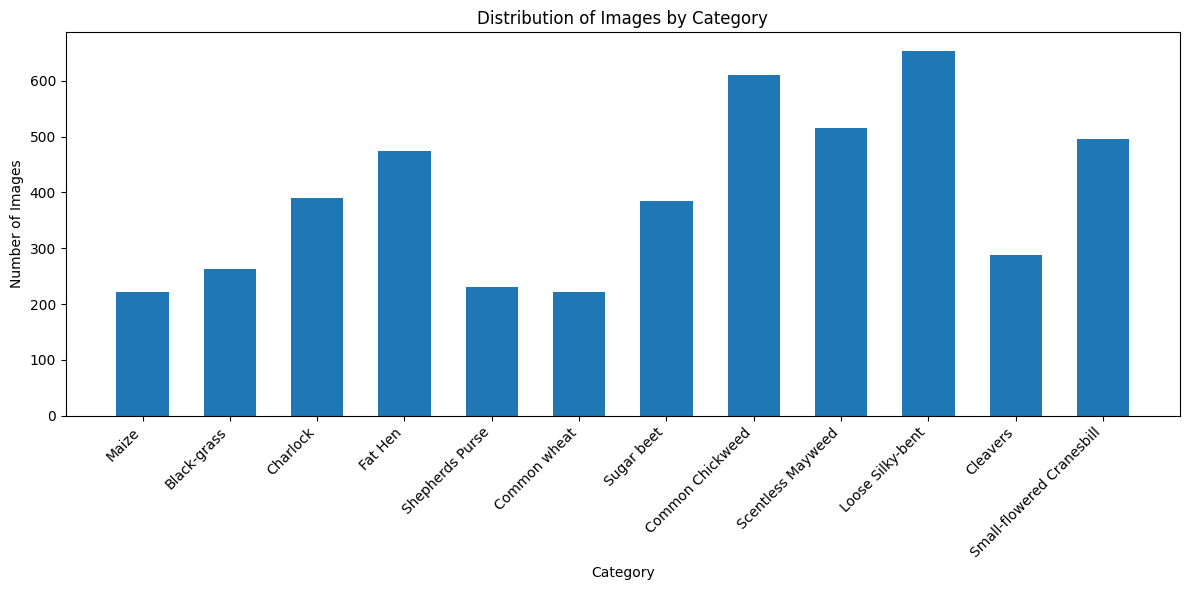

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(allCategories, catLengthList, width = 0.6)
plt.title('Distribution of Images by Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Let's see some examples from those categories.

In [ ]:
def displayPlantImages(imageNum):
    # Create a 3x4 grid of subplots
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))

    # Iterate through the categories and display example images
    for indexNum, eachCat in enumerate(allCategories):
        catPath = os.path.join(trainDir, eachCat)
        image_files = [f for f in os.listdir(catPath) if f.endswith(('.png'))]
        imgPath = os.path.join(catPath, image_files[imageNum]) #Grab the first image
        img = plt.imread(imgPath)
        row = indexNum // 4
        col = indexNum % 4
        axes[row, col].imshow(img)
        axes[row, col].set_title(eachCat)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

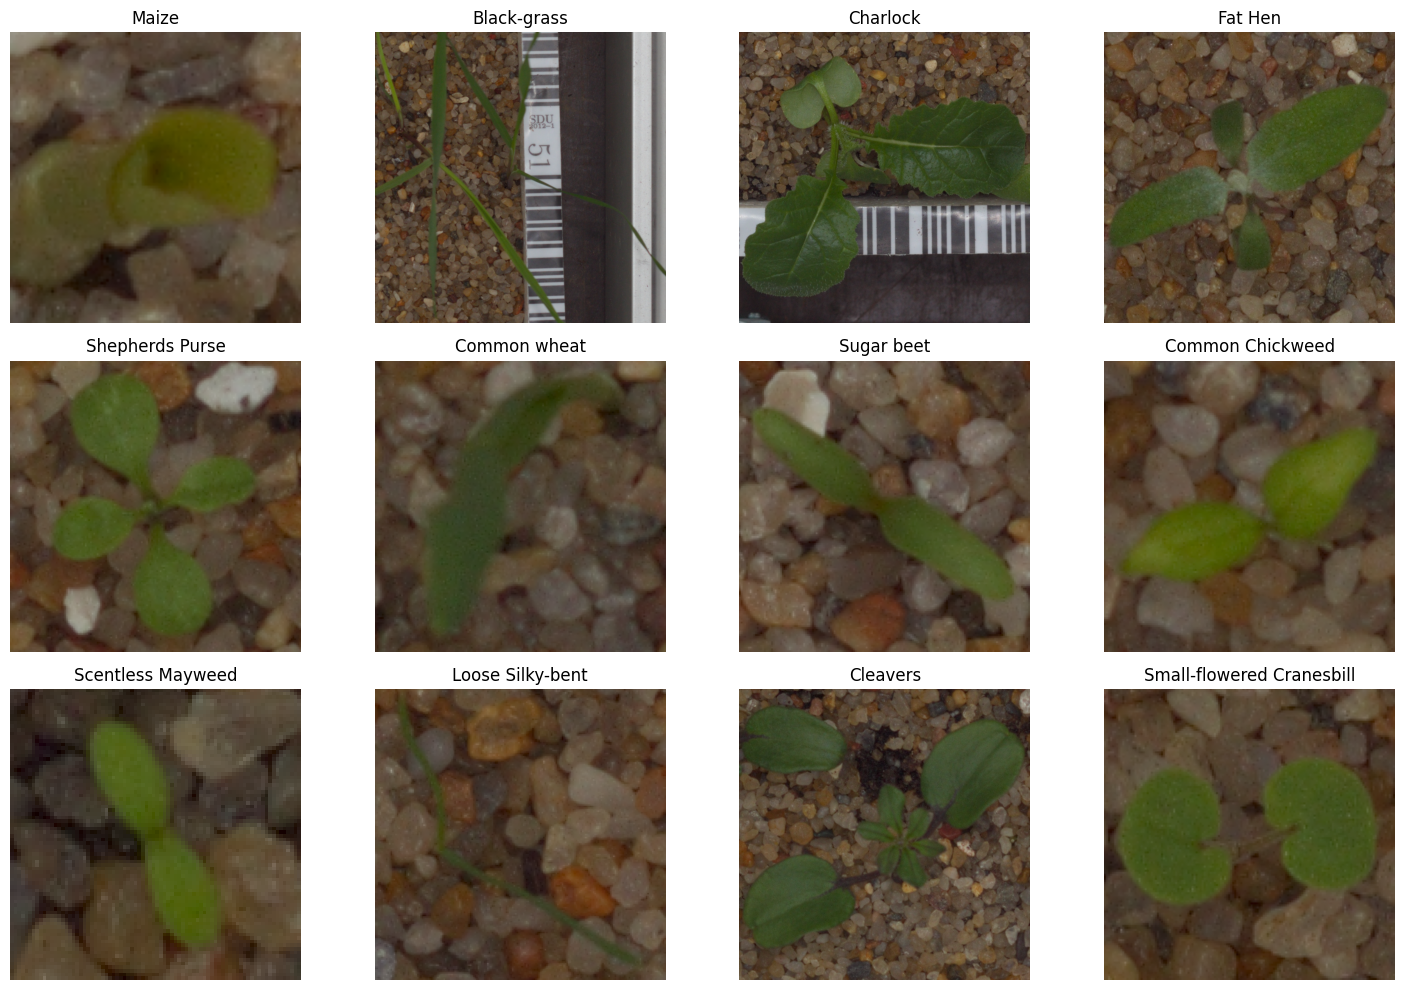

In [ ]:
displayPlantImages(0)

Here are a couple more images of each category.

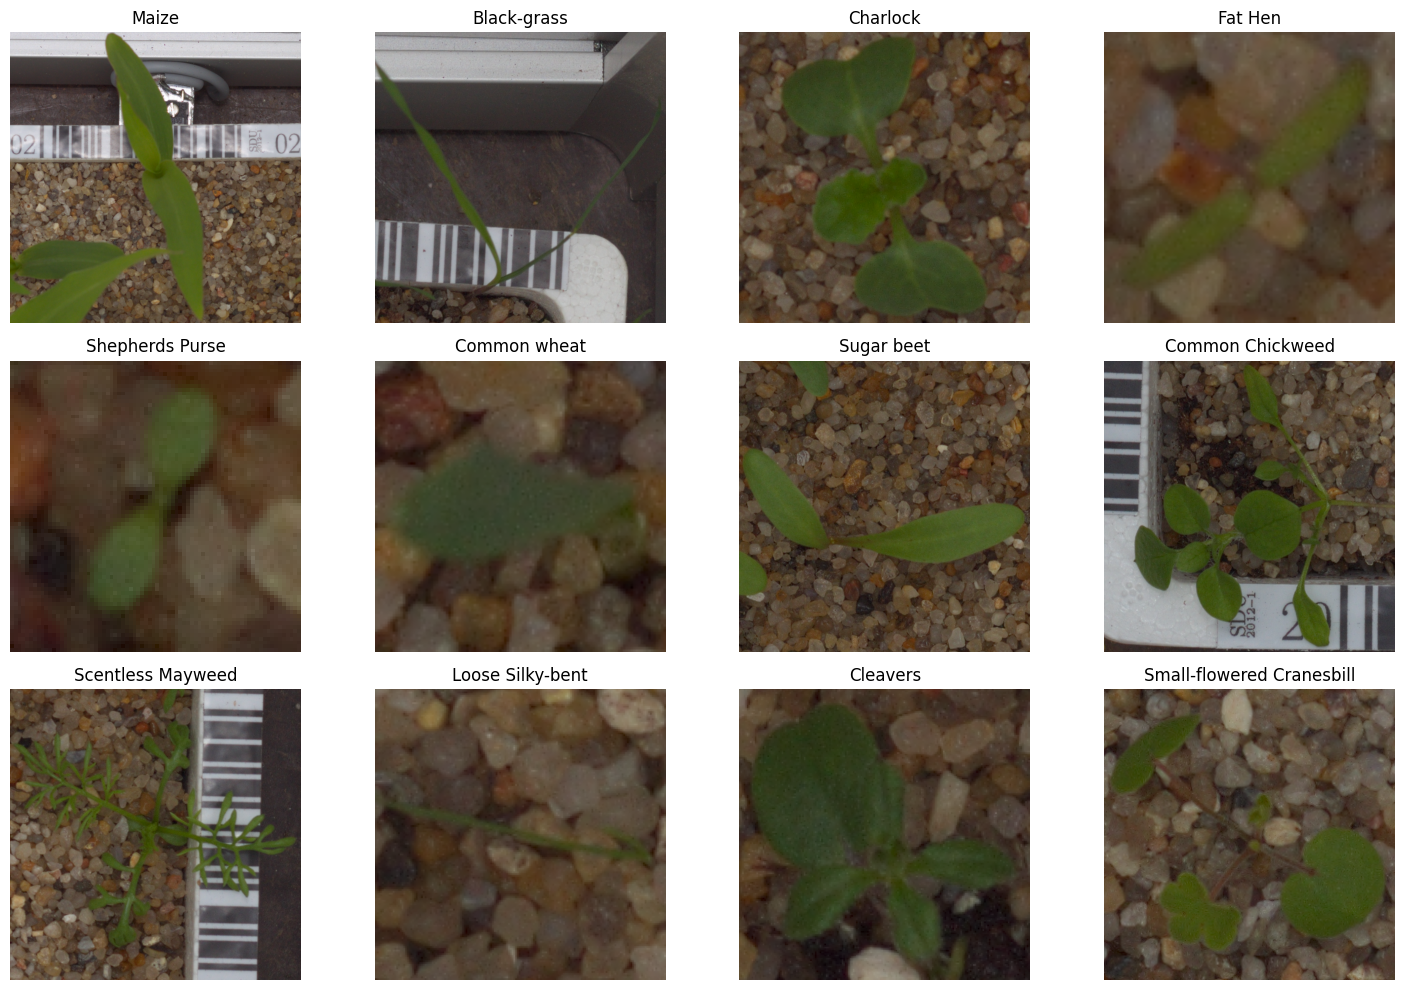

In [ ]:
displayPlantImages(1)

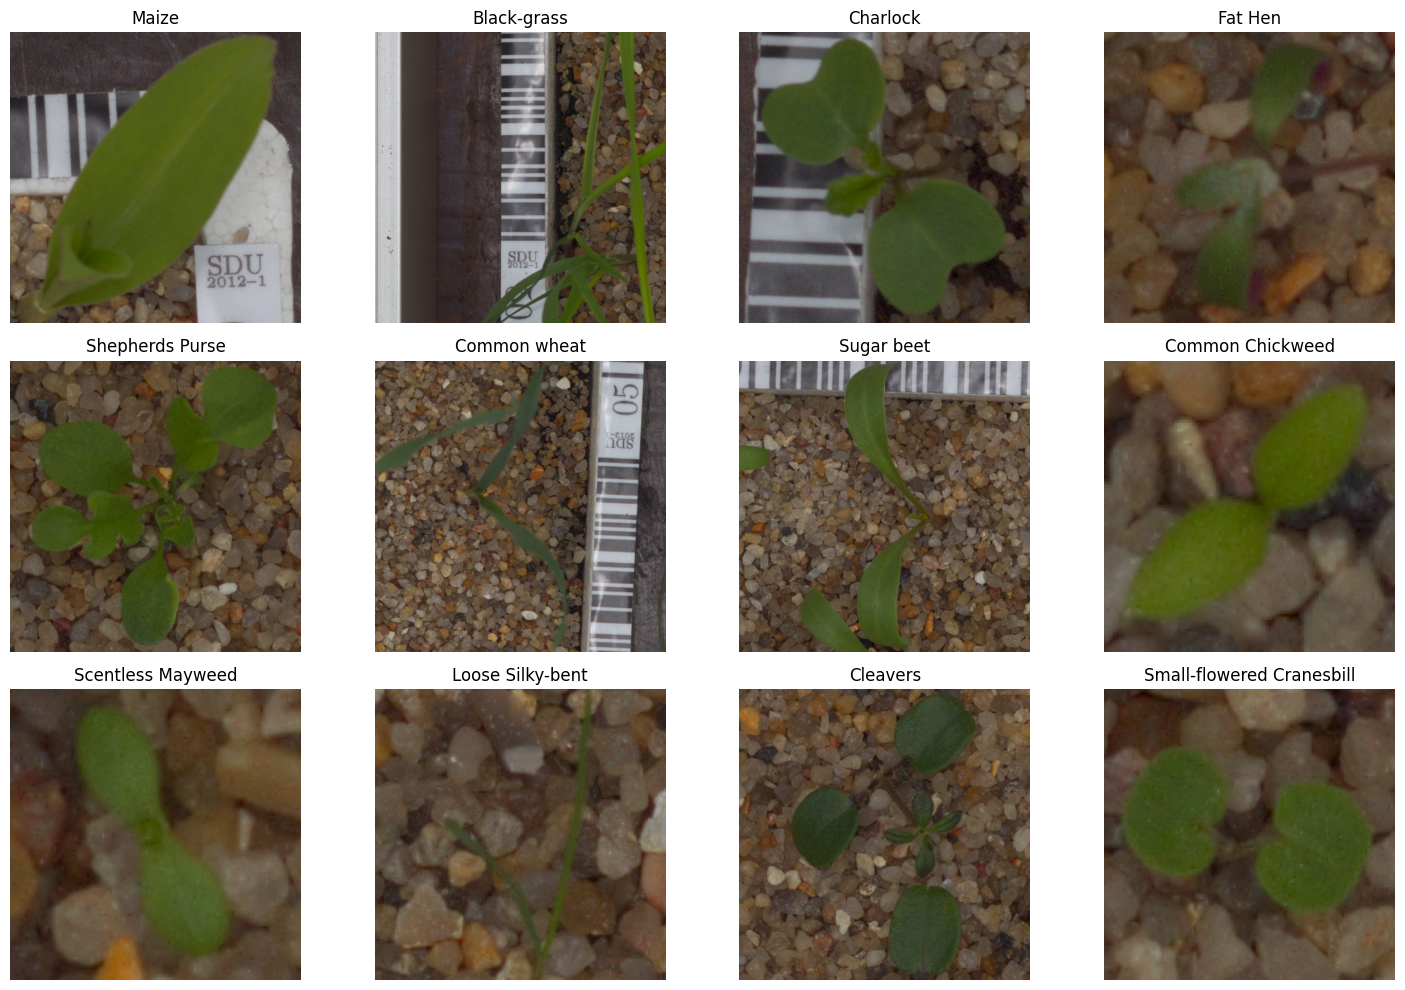

In [ ]:
displayPlantImages(2)

In [ ]:
#With all of those different image sizes, let's standardize them all
targetSize = 224
f32 = "float32"

### Load and Split the Data

Since there's no way to tell what the true values are for the test data images, I need to split the training data to save a chunk for validation. First things first, I need to load the data into a structure for splitting.

In [ ]:
# Create a class to load all these images for splitting
class Dataset:
    def __init__(self):
        self.xPath = trainDir
        self.classes = os.listdir(self.xPath)
        self.xData = []
        self.yData = []

    def prepImage(self, image):
        image = np.array(image, dtype = f32)
        image = cv2.resize(image, (targetSize, targetSize))
        image = np.reshape(image, (targetSize, targetSize, 3))
        image /= 255.0
        return np.array(image, dtype = f32)

    def pathToImages(self, path):
        imagePath = os.listdir(path)
        for eachFile in imagePath:
            image = cv2.imread(path + '/' + eachFile)
            self.xData.append(self.prepImage(image))
            self.yData.append(self.classes.index(path.split('/')[-1]))

    def loadAllData(self):
        for eachClass in self.classes:
            self.pathToImages(self.xPath + '/' + eachClass)

        self.xData = np.array(self.xData, dtype = f32)
        self.yData = to_categorical(self.yData)
        self.yData = np.array(self.yData, dtype = f32)

        return train_test_split(self.xData, self.yData, random_state = 100)


In [ ]:
dataset = Dataset()
x_train, x_test, y_train, y_test = dataset.loadAllData()
y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

In [ ]:
def ImageGenerator():
    return ImageDataGenerator(rotation_range = 20,
                              zoom_range = 0.15,
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,
                              shear_range = 0.15,
                              horizontal_flip = True,
                              fill_mode = 'nearest')

## Create the Model

I'll pull together a convolutional neural network model with a dish of LSTM. With multiple dense layers, the result will have over 100 million trainable parameters. I'm glad I've got a good GPU in this Colab session.

In [ ]:
class CNNModel:
    def __init__(self, shape, cnn):
        self.shape = shape
        self.mInput = keras.layers.Input(shape = (self.shape[0], self.shape[1], self.shape[2]),
                                         dtype = f32)
        self.cnn = cnn(weights = 'imagenet', include_top = False,
                       input_tensor = self.mInput)
        # Alternate between non-/trainable layers
        for eachLayer in self.cnn.layers[: len(self.cnn.layers) // 2 ]:
            eachLayer.trainable = True
        for eachLayer in self.cnn.layers[len(self.cnn.layers) // 2 :]:
            eachLayer.trainable = False
        self.model = 0

        self.modelPath = os.path.join(MODEL_DIR, 'cnnmodel.keras')
        self.createModel()

    def createModel(self):
        kAct = 'selu'
        kInit = 'lecun_normal'
        x = keras.layers.Flatten()(self.cnn.output)
        x = keras.layers.Dense(1024, activation = kAct, kernel_initializer = kInit)(x)
        x = keras.layers.Dropout(0.1)(x)
        x = keras.layers.Dense(512, activation = kAct, kernel_initializer = kInit)(x)
        x = keras.layers.Dropout(0.1)(x)
        x = keras.layers.Dense(256, activation = kAct, kernel_initializer = kInit)(x)
        x = keras.layers.Dropout(0.1)(x)
        x = keras.layers.Dense(128, activation = kAct, kernel_initializer = kInit)(x)
        x = keras.layers.Dropout(0.1)(x)
        x = keras.layers.Dense(64, activation = kAct, kernel_initializer = kInit)(x)
        x = keras.layers.Dropout(0.1)(x)
        x = keras.layers.Dense(32, activation = kAct, kernel_initializer = kInit)(x)
        x = keras.layers.Dropout(0.1)(x)

        outputLayer = keras.layers.Dense(12, activation = 'softmax')(x)

        self.model = keras.models.Model(inputs = self.mInput,
                                        outputs = outputLayer,
                                        name = 'CNNModel')

    def plotLA(self):
        #Plot Loss by Epoch
        plt.plot(self.result.history['loss'], label = 'Training')
        plt.plot(self.result.history['val_loss'], label = 'Testing')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss by Epoch')
        plt.legend()
        plt.show()
        #Plot Accuracy by Epoch
        plt.plot(self.result.history['accuracy'], label = 'Training')
        plt.plot(self.result.history['val_accuracy'], label = 'Testing')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy by Epoch')
        plt.legend()
        plt.show()

    def scoring(self):
        y_test_0 = [np.argmax(i) for i in y_test]
        y_pred_0 = [np.argmax(i) for i in self.model.predict(x_test)]
        cm = confusion_matrix(y_test_0, y_pred_0)
        print(classification_report(y_test_0, y_pred_0))
        df_cm = pd.DataFrame(cm)
        plt.figure(figsize = (10, 7))
        sn.heatmap(df_cm, annot = True, fmt = 'd',
                   linewidths = 0.5, cmap = 'Reds')

    def compileFit(self, lr = 1e-4, epochs = 100):
        optimizer = keras.optimizers.Adam(learning_rate = lr)
        checkpoint = keras.callbacks.ModelCheckpoint(self.modelPath,
                                                     save_best_only = True)
        self.model.compile(loss = 'categorical_crossentropy',
                           optimizer = optimizer,
                           metrics = ['accuracy'])
        self.result = self.model.fit(x = ImageGenerator().flow(x_train, y_train),
                                     epochs = epochs,
                                     validation_data = (x_test, y_test),
                                     shuffle = True,
                                     batch_size = 32,
                                     callbacks = [checkpoint])


In [ ]:
netModel1 = CNNModel((targetSize, targetSize, 3), keras.applications.resnet.ResNet101)
print (netModel1.model.summary())


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "CNNModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 146,119,404 (557.40 MB)

 Trainable params: 115,375,980 (440.12 MB)

 Non-trainable params: 30,743,424 (117.28 MB)

None


In [ ]:
netModel1.compileFit(epochs = 15)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 162s 764ms/step - accuracy: 0.2972 - loss: 2.6481 - val_accuracy: 0.0530 - val_loss: 3.5043
Epoch 2/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 40s 330ms/step - accuracy: 0.7857 - loss: 0.6631 - val_accuracy: 0.0513 - val_loss: 6.2247
Epoch 3/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 333ms/step - accuracy: 0.8590 - loss: 0.4514 - val_accuracy: 0.1086 - val_loss: 5.3460
Epoch 4/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 329ms/step - accuracy: 0.8969 - loss: 0.3383 - val_accuracy: 0.1120 - val_loss: 6.6100
Epoch 5/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 40s 333ms/step - accuracy: 0.9046 - loss: 0.3124 - val_accuracy: 0.1330 - val_loss: 7.3847
Epoch 6/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 40s 333ms/step - accuracy: 0.9317 - loss: 0.2296 - val_accuracy: 0.0749 - val_loss: 5.8821
Epoch 7/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 330ms/step - accuracy: 0.9175 - loss: 0.2427 - val_accuracy: 0.1515 - val_loss: 6.5969
Epoch 8/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 329ms/step - accuracy: 0.9384 - loss: 0.1826 - va

## Results

I included some output reporting within the model class I created. Let's see what it tells us.


38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        54
           1       0.67      0.90      0.77        62
           2       1.00      1.00      1.00       104
           3       0.98      0.98      0.98       133
           4       0.98      0.95      0.96        58
           5       0.98      0.93      0.95        54
           6       0.97      0.96      0.96        89
           7       0.98      0.99      0.98       153
           8       0.96      0.98      0.97       121
           9       0.95      0.85      0.90       160
          10       1.00      0.99      0.99        76
          11       1.00      0.99      1.00       124

    accuracy                           0.96      1188
   macro avg       0.96      0.96      0.95      1188
weighted avg       0.96      0.96      0.96      1188



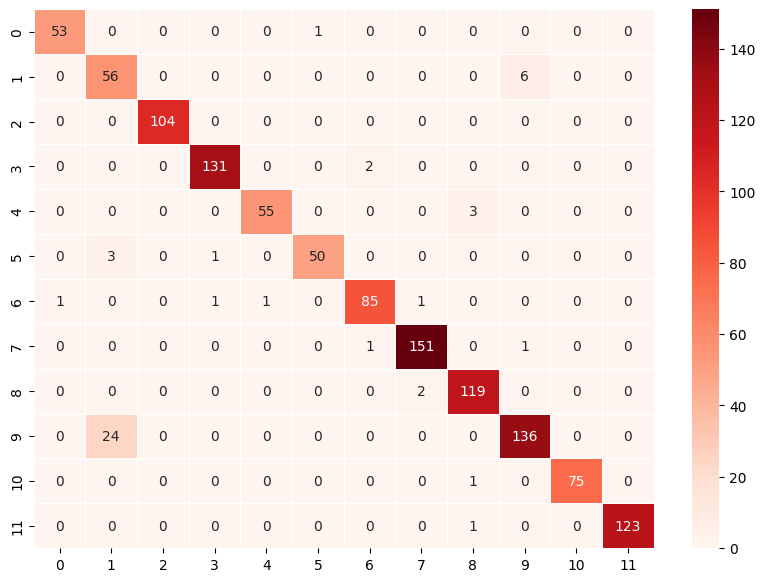

In [ ]:
netModel1.scoring()

F1 accuracy of 96% sounds pretty good. From the confusion matrix, it appears that the only category with more than three mistakes was Category 1, which was Black-grass. (That was also the only category with an F1 of less than 90%.) Looking at the example images, I would suspect the relative lack of leaf detail, since they look just like skinny, straight blades of grass.

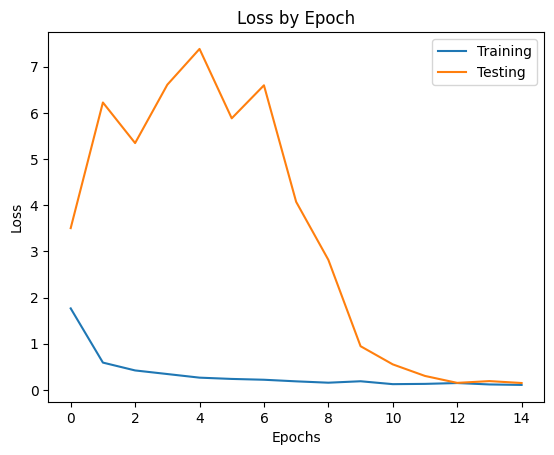

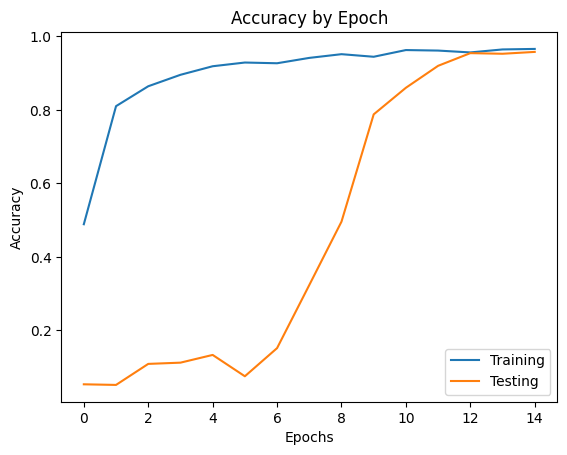

In [ ]:
netModel1.plotLA()

The model almost reached its peak of validation accuracy by the 13th epoch. (Those plots are always off by one for me. I'm not sure why.) The 15th and last epoch still showed slight improvement over the 13th.

I had joined the competition because it was a requirement to access the data. I might as well see how well my model's classification results stack up on the leaderboard.

In [ ]:
def prepImage(image):
    image = np.array(image, dtype = f32)
    image = cv2.resize(image, (targetSize, targetSize))
    image = np.reshape(image, (targetSize, targetSize, 3))
    image /= 255.0

    return np.array(image, dtype = f32)

xDataTest = []

def pathToImages(path):
    global x_data_test
    image = cv2.imread(path)
    xDataTest.append(prepImage(image))

x_path = testDir
imagePath = os.listdir(x_path)

for eachFile in imagePath:
    pathToImages(x_path + '/' + eachFile)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
classes = os.listdir(trainDir)
modelPath = os.path.join(MODEL_DIR, 'cnnmodel.keras')
netModel1.model = keras.models.load_model(modelPath)

xDataTest = np.array(xDataTest, dtype = f32)
predArray = netModel1.model.predict(xDataTest)
dfOutput = pd.DataFrame()
dfOutput['file'] = imagePath
dfOutput['species'] = [classes[np.argmax(pred)] for pred in predArray]
dfOutput.index = dfOutput['file']
dfOutput = dfOutput.drop('file', axis = 1)
dfOutput.to_csv('/content/drive/My Drive/plantSubmission.csv')

25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 276ms/step


In [ ]:
dfOutput.head()

species
file                                    
d488a4fe1.png               Common wheat
593896f83.png           Common Chickweed
a006a475c.png           Common Chickweed
b4f7c9214.png                Black-grass
c88ebfb47.png  Small-flowered Cranesbill

Here's how my submission scored:
![My Score](https://carload.com/g/result2.png)

## Conclusion / Discussion

My submission result of ~95% was about the same as my F1 score, so it wasn't a surprise. That score would have ranked decently well if I'd sent it during the competition; publicly posted scores from that period range from 0.978 to 0.767 and lower.

The model I created worked well with almost all categories of seedlings. It could be a useful tool in automatically detecting certain weeds among some fields of crops.

Future work could include finding a wider range of training images. I believe that beefing up with more model layers on the limited number of images in this dataset could just lead to overfitting.